# Packages

In [33]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
import ast

import pandas as pd
import geopandas as gpd
import numpy as np

# Loading data

In [34]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

In [35]:
football = pd.read_csv(RAW_DIR / "football_new.csv")

# Exporatory Data Analysis

In [36]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'second', 'minute',
       'team', 'team_id', 'player', 'player_id', 'position', 'play_pattern',
       'type', 'under_pressure', 'shot_deflected', 'shot_open_goal',
       'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location',
       'shot_outcome', 'shot_body_part', 'shot_first_time', 'shot_technique',
       'shot_key_pass_id,', 'shot_one_on_one'],
      dtype='object')

In [37]:
football["shot_type"].value_counts()

shot_type
Open Play    43096
Free Kick     2124
Penalty        486
Corner          13
Name: count, dtype: int64

In [38]:
football.groupby(["shot_type"])["shot_outcome"].count()

shot_type
Corner          13
Free Kick     2124
Open Play    43096
Penalty        486
Name: shot_outcome, dtype: int64

Are we going to look at all the periods? Overtime and also penalty kick?

In [39]:
football["period"].value_counts().sort_index()

period
1    20814
2    24905
Name: count, dtype: int64

I am gonna transform shot outcome column into a 0 and 1 column

In [40]:
football["shot_outcome"].unique().tolist()

['Off T',
 'Goal',
 'Blocked',
 'Saved',
 'Wayward',
 'Post',
 'Saved Off Target',
 'Saved to Post']

I will transform timestamp into a minute ceil column (e.g., 4:32 -> 5th minute)

In [41]:
football["timestamp"].unique()

array(['00:04:21.052', '00:06:27.395', '00:08:16.762', ...,
       '00:45:24.473', '00:45:25.517', '00:47:47.998'],
      shape=(45346,), dtype=object)

I will transform location to a x and y column by making it a list first

In [42]:
football["location"].head()

0    [108.1, 31.2]
1    [110.9, 42.6]
2    [117.9, 29.1]
3    [101.8, 27.6]
4    [109.3, 26.5]
Name: location, dtype: object

<Axes: xlabel='shot_body_part'>

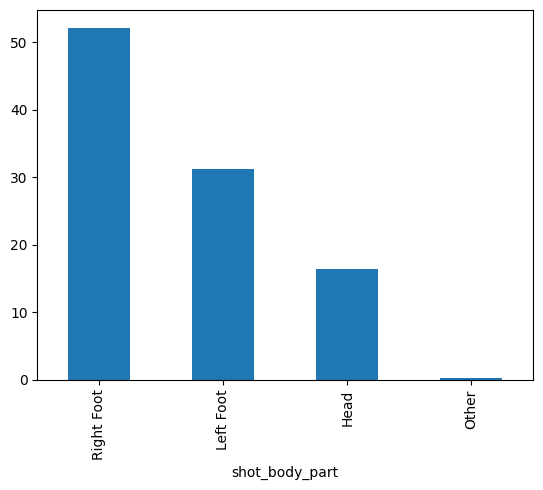

In [43]:
(football["shot_body_part"].value_counts(normalize=True) * 100).plot(kind='bar')

There is no freeze frame data for penalty kicks which makes sense

In [44]:
football[football["shot_freeze_frame"].isna()]["shot_type"].value_counts()

shot_type
Penalty    434
Name: count, dtype: int64

In [45]:
football["shot_outcome"].value_counts()

shot_outcome
Off T               15089
Blocked             11292
Saved               10744
Goal                 4706
Wayward              2704
Post                  870
Saved Off Target      161
Saved to Post         153
Name: count, dtype: int64

# Processing Data

In [46]:
def process_shot_outcome(df):
    outcome_mapping = {
        'Off T': 0,
        'Goal': 1,
        'Blocked': 0,
        'Saved': 0,
        'Wayward': 0,
        'Post': 0,
        'Saved Off Target': 0,
        'Saved to Post': 0
    }

    df['shot_outcome_encoded'] = df['shot_outcome'].map(outcome_mapping)
    return df

def process_shot_body_part(df, add_combine_feet=True):
    dummies = pd.get_dummies(df['shot_body_part'], prefix='body_part', drop_first=False, dtype=int)
    dummies.columns = dummies.columns.str.lower().str.replace(" ", "_")

    if add_combine_feet:
        dummies['body_part_foot'] = dummies.get('body_part_left_foot', 0) + dummies.get('body_part_right_foot', 0)
        dummies.drop(columns=['body_part_left_foot', 'body_part_right_foot'], inplace=True)

    df = pd.concat([df, dummies], axis=1)
    return df

def process_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
    df['time_only'] = df['timestamp'].dt.time
    df['minute'] = df['timestamp'].dt.minute # maybe remove?
    df['second'] = df['timestamp'].dt.second # maybe remove?
    df['minute_ceil'] = df['timestamp'].dt.ceil('min').dt.minute
    return df

def process_location(df):
    df["location"] = df['location'].apply(ast.literal_eval)
    df[["x", "y"]] = pd.DataFrame(df["location"].tolist(), index=df.index)
    return df

def distance_from_goal(df):
    df['distance_from_goal_center'] = np.sqrt((120 - df['x'])**2 + (40 - df['y'])**2) # need to double check
    df['distance_from_goal_left_post'] = np.sqrt((120 - df['x'])**2 + (36 - df['y'])**2)
    df['distance_from_goal_right_post'] = np.sqrt((120 - df['x'])**2 + (44 - df['y'])**2)

    return df

def process_one_hot_encoding(df, cols_to_process):
    # one hot encoding
    for col in cols_to_process:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=False, dtype=int)
        dummies.columns = dummies.columns.str.lower().str.replace(" ", "_")
        df = pd.concat([df, dummies], axis=1)
    return df

def encode_true_false(df, cols_to_process):
    # Convert True into 1 and NaN into 0
    for col in cols_to_process:
        df[col] = df[col].fillna(False).astype(int)
    return df


def shot_angle(x, y, 
               post1=(120, 36),   # top post
               post2=(120, 44)):  # bottom post
    """
    Returns shot angle in radians using absolute difference of atan2 angles.
    x, y: shooter coordinates.
    post1, post2: (x,y) of both posts.
    """
    a1 = math.atan2(post1[1] - y, post1[0] - x)
    a2 = math.atan2(post2[1] - y, post2[0] - x)
    return abs(a2 - a1)


def get_opposition_goalkeeper_location(freeze_frame):
    """
    Returns the location of the opposition goalkeeper
    (position='Goalkeeper' and teammate=False).
    """
    freeze_frame = freeze_frame.ast.literal_eval

    for player in freeze_frame:
        if (
            player.get("position", {}).get("name") == "Goalkeeper"
            and player.get("teammate") is False
        ):
            return player.get("location")
    return None

drop penalties columns

In [47]:
football

,id,index,match_id,period,timestamp,second,minute,team,team_id,player,...,shot_type,shot_statsbomb_xg,shot_freeze_frame,location,shot_outcome,shot_body_part,shot_first_time,shot_technique,"shot_key_pass_id,",shot_one_on_one
0,ba46e9d6-e828-4599-952c-39c1f7d22659,263,3890561,1,00:04:21.052,21,4,Hoffenheim,175,Tarik Elyounoussi,...,Open Play,0.087901,"[{'location': [115.7, 50.0], 'player': {'id': ...","[108.1, 31.2]",Off T,Left Foot,True,Half Volley,NaN,NaN
1,85d67225-30fb-47c8-b478-cf568941a164,353,3890561,1,00:06:27.395,27,6,Schalke 04,181,Klaas-Jan Huntelaar,...,Open Play,0.160274,"[{'location': [98.4, 33.1], 'player': {'id': 8...","[110.9, 42.6]",Goal,Right Foot,True,Volley,NaN,NaN
2,adac17d3-5e67-4e8c-b482-4bae2f36e06e,410,3890561,1,00:08:16.762,16,8,Hoffenheim,175,Kevin Volland,...,Open Play,0.016036,"[{'location': [101.9, 52.4], 'player': {'id': ...","[117.9, 29.1]",Blocked,Left Foot,True,Half Volley,NaN,NaN
3,abffd193-62bc-4c8d-8636-1e3f0f0ebbe5,624,3890561,1,00:13:55.721,55,13,Schalke 04,181,Jean-Eric Maxim Choupo-Moting,...,Open Play,0.527759,"[{'location': [93.1, 35.3], 'player': {'id': 9...","[101.8, 27.6]",Goal,Left Foot,NaN,Normal,NaN,NaN
4,d9cea903-f92a-40e1-a393-1a849d83f157,749,3890561,1,00:17:16.953,16,17,Schalke 04,181,Klaas-Jan Huntelaar,...,Open Play,0.074020,"[{'location': [88.4, 69.5], 'player': {'id': 3...","[109.3, 26.5]",Saved,Right Foot,NaN,Normal,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,2d60277a-da24-4e8a-aa97-42f2cb0830fa,3758,3878540,2,00:44:37.645,37,89,Lazio,236,Danilo Cataldi,...,Open Play,0.030999,"[{'location': [102.4, 37.8], 'player': {'id': ...","[98.6, 40.4]",Blocked,Left Foot,NaN,Normal,NaN,NaN
45715,7d4e50ce-7ecd-44a1-b242-d1001d05417a,3785,3878540,2,00:45:22.885,22,90,Bologna,240,Franco Brienza,...,Open Play,0.042634,"[{'location': [115.9, 42.2], 'player': {'id': ...","[103.0, 51.3]",Blocked,Left Foot,True,Normal,NaN,NaN
45716,fa4f5417-a44e-4d14-b4f5-05925d778a07,3789,3878540,2,00:45:24.473,24,90,Bologna,240,Franco Brienza,...,Open Play,0.038101,"[{'location': [116.3, 42.0], 'player': {'id': ...","[103.8, 51.4]",Wayward,Right Foot,True,Half Volley,NaN,NaN
45717,7268aefc-277a-40bc-9995-5830039d6a5e,3792,3878540,2,00:45:25.517,25,90,Bologna,240,Matteo Brighi,...,Open Play,0.063746,"[{'location': [102.8, 51.2], 'player': {'id': ...","[110.0, 39.4]",Saved,Head,NaN,Normal,NaN,NaN


In [48]:
football["shot_type"].unique()

array(['Open Play', 'Free Kick', 'Penalty', 'Corner'], dtype=object)

In [49]:
# keep only open play or free kick
football = football[(football["shot_type"] == "Open Play") | (football["shot_type"] == "Free Kick")]

# 

In [51]:
football = process_shot_outcome(football)
football = process_timestamp(football)
football = process_location(football)
football = distance_from_goal(football)
football = process_shot_body_part(football, True)
football = encode_true_false(football, ["shot_open_goal", "under_pressure", "shot_deflected", "shot_one_on_one", "shot_first_time"])
football = process_one_hot_encoding(football, ["shot_technique", "play_pattern", "shot_type"]) # removed position
football["shot_freeze_frame"] = football["shot_freeze_frame"].apply(ast.literal_eval)
football["goalkeeper_location"] = football["shot_freeze_frame"].apply(get_opposition_goalkeeper_location)
football["shot_angle"] = football.apply(lambda row: shot_angle(row["x"], row["y"]), axis=1)


# show all columns
pd.set_option('display.max_columns', None)

football

/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_2450/2192601308.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shot_outcome_encoded'] = df['shot_outcome'].map(outcome_mapping)
/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_2450/2192601308.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_2450/2192601308.py:29: SettingWithCopyWarning: 
A value 

AttributeError: 'list' object has no attribute 'ast'

In [ ]:
football.to_csv(PROCESSED_DIR / "football_processed.csv", index=False)

In [ ]:
test = football['shot_freeze_frame'][:10].apply(ast.literal_eval)